# Importing Necessary Libraries

In [16]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings('ignore')

# Loading the Dataset

In [17]:
# Loading the dataset
DATA_DIRECTORY = "/kaggle/input/categorical-continuous/"

train_data = pd.read_csv(DATA_DIRECTORY + "train.csv")
test_data = pd.read_csv(DATA_DIRECTORY + "test.csv")

# Plotting Numerical Features

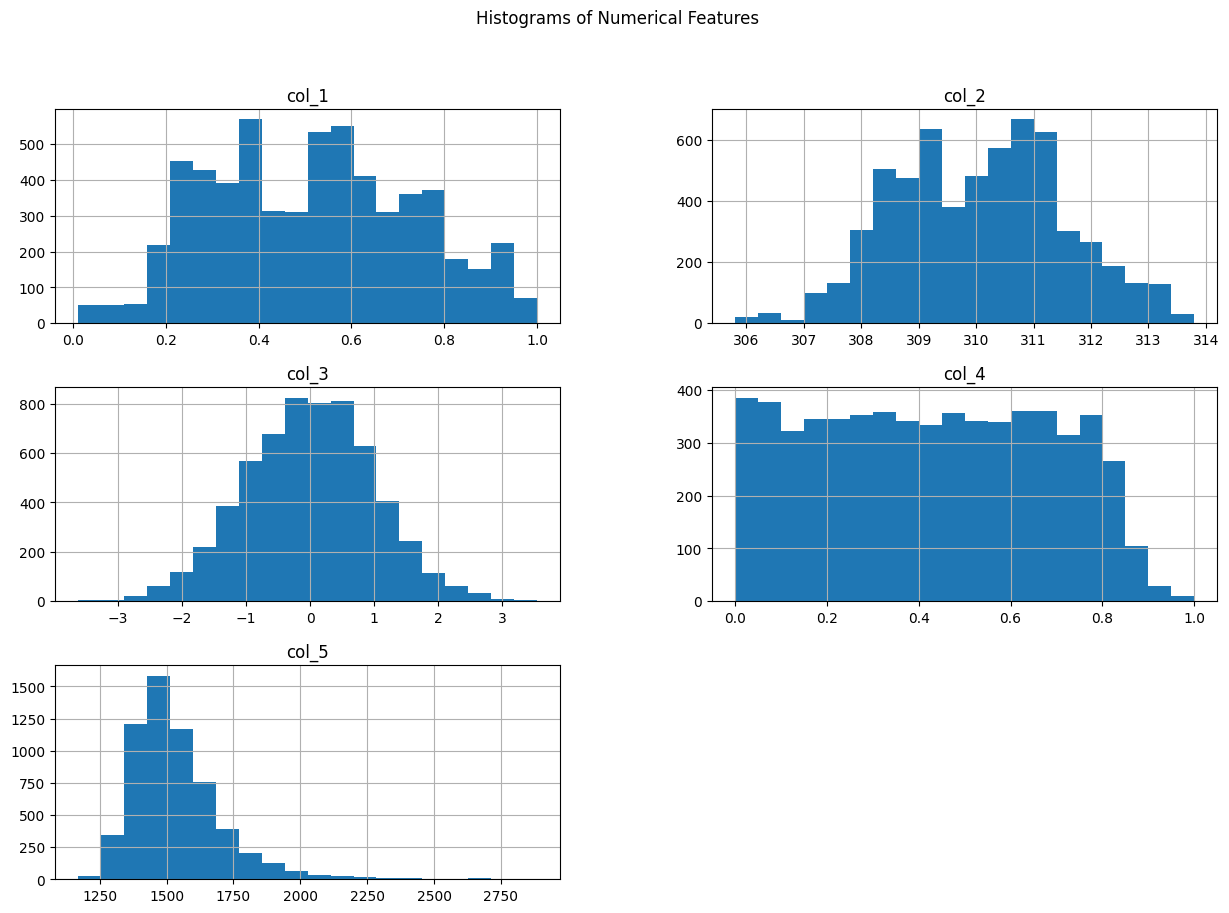

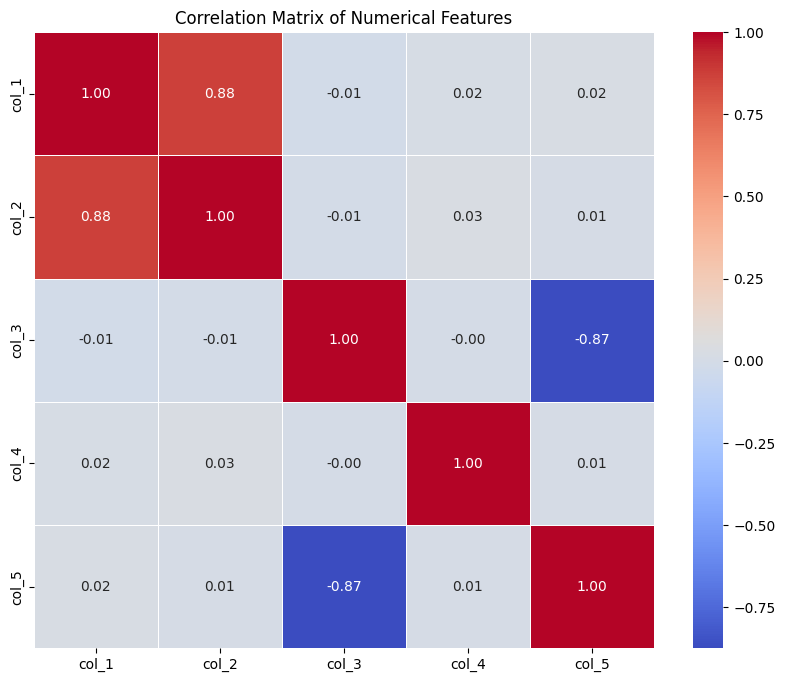

In [18]:
numerical_features = ['col_1', 'col_2', 'col_3', 'col_4', 'col_5']
train_data[numerical_features].hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Data Preprocessing

In [19]:
# Removing space from 'col_0' feature names
train_data['col_0'] = train_data['col_0'].str.replace(' ', '')
test_data['col_0'] = test_data['col_0'].str.replace(' ', '')

# Defining the order of categories for 'col_0' and 'y'
col_0_order = ['A0', 'A1', 'A2']
y_order = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Plotting Count for Categorical Feature and Target Variable

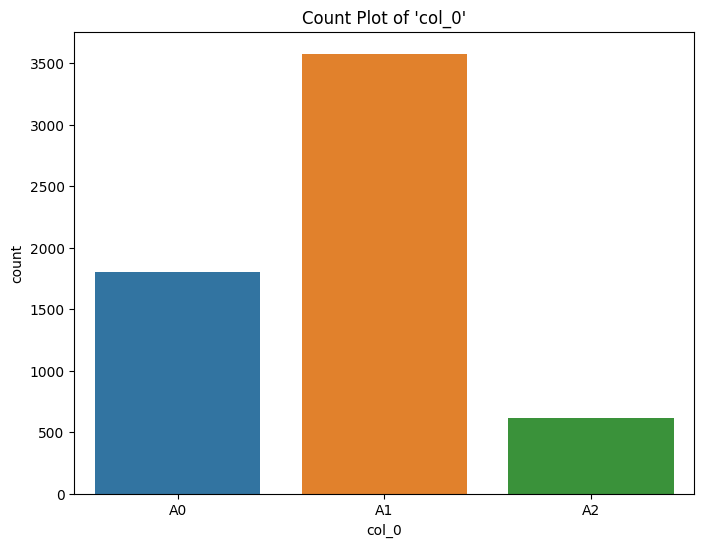

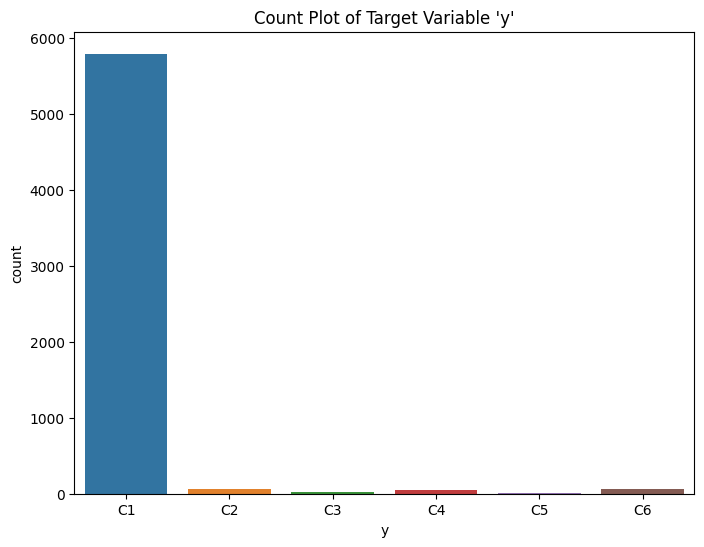

In [20]:
# Plotting count plot for categorical feature 'col_0'
plt.figure(figsize=(8, 6))
sns.countplot(x='col_0', data=train_data, order=col_0_order)
plt.title("Count Plot of 'col_0'")
plt.show()

# Plotting count plot for target variable 'y'
plt.figure(figsize=(8, 6))
sns.countplot(x='y', data=train_data, order=y_order)
plt.title("Count Plot of Target Variable 'y'")
plt.show()

# Data Anlyzing

In [21]:
# Displaying information about the dataset
print("Dataset Information:")
print(tabulate(train_data.info(), headers='keys', tablefmt='pretty'))

print("\nSummary Statistics for Numerical Features:")
print(tabulate(train_data.describe(), headers='keys', tablefmt='pretty'))

print("\nCategorical Column (col_0) Distribution:")
print(tabulate(train_data['col_0'].value_counts().reset_index(), headers=['Target', 'Count'], tablefmt='pretty'))

print("\nClass Distribution for Target Variable:")
print(tabulate(train_data['y'].value_counts().reset_index(), headers=['Target', 'Count'], tablefmt='pretty'))

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      6000 non-null   int64  
 1   col_0   6000 non-null   object 
 2   col_1   6000 non-null   float64
 3   col_2   6000 non-null   float64
 4   col_3   6000 non-null   float64
 5   col_4   6000 non-null   float64
 6   col_5   6000 non-null   int64  
 7   y       6000 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 375.1+ KB


Summary Statistics for Numerical Features:
+-------+--------------------+---------------------+--------------------+------------------------+--------------------+--------------------+
|       |         ID         |        col_1        |       col_2        |         col_3          |       col_4        |       col_5        |
+-------+--------------------+---------------------+--------------------+------------------------+--------------

# Encoding the Categorical Values

In [22]:
label_encoder = LabelEncoder()

# Encoding the categorical values using LabelEncoder
train_data['y'] = label_encoder.fit_transform(train_data['y'])
train_data['col_0'] = label_encoder.fit_transform(train_data['col_0'])
test_data['col_0'] = label_encoder.transform(test_data['col_0'])

# Splitting the Dataset

In [23]:
# Splitting the dataset into features (X) and target variable (y)
X = train_data.drop(columns=['ID', 'y'])
y = train_data['y']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
label_map = {0: 'C1', 1: 'C2', 2: 'C3', 3: 'C4', 4: 'C5', 5: 'C6'}

# Random Forest Classifier

In [24]:
# Initializing the RandomForestClassifier
model = RandomForestClassifier()

# Training the model
model.fit(X_train, y_train)

# Predicting on the validation set
val_predictions = model.predict(X_val)

# Evaluating the model
accuracy = accuracy_score(y_val, val_predictions)
print("Accuracy on validation set:", accuracy)
print("\nClassification Report:")
print(classification_report(y_val, val_predictions, zero_division='warn'))

# Predicting on the test set
test_predictions = model.predict(test_data.drop(columns=['ID']))
test_predictions = [label_map[label] for label in test_predictions]

# Creating a DataFrame for the solution and save to CSV
solution_df = pd.DataFrame({'ID': test_data['ID'], 'y': test_predictions})
solution_df.to_csv("Siddiqur_Rahman_Random_Forest.csv", index=False)

Accuracy on validation set: 0.9766666666666667

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1158
           1       0.88      0.64      0.74        11
           2       0.00      0.00      0.00         6
           3       1.00      0.30      0.46        10
           4       0.00      0.00      0.00         2
           5       0.86      0.46      0.60        13

    accuracy                           0.98      1200
   macro avg       0.62      0.40      0.46      1200
weighted avg       0.97      0.98      0.97      1200



# Synthetic Minority Oversampling Technique (SMOTE)

In [25]:
# Applying SMOTE to oversample the minority classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initializing the RandomForestClassifier with class weights
model = RandomForestClassifier()

# Training the model on the resampled data
model.fit(X_train_resampled, y_train_resampled)

# Predicting on the validation set
val_predictions = model.predict(X_val)

# Evaluating the model
accuracy = accuracy_score(y_val, val_predictions)
print("Accuracy on validation set after SMOTE:", accuracy)
print("\nClassification Report after SMOTE:")
print(classification_report(y_val, val_predictions))

# Predicting on the test set
test_predictions = model.predict(test_data.drop(columns=['ID']))
test_predictions = [label_map[label] for label in test_predictions]

# Creating a DataFrame for the solution and save to CSV
solution_df = pd.DataFrame({'ID': test_data['ID'], 'y': test_predictions})
solution_df.to_csv("Siddiqur_Rahman_Random_Forest_SMOTE.csv", index=False)

Accuracy on validation set after SMOTE: 0.9575

Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1158
           1       0.67      0.73      0.70        11
           2       0.13      0.33      0.19         6
           3       0.62      0.80      0.70        10
           4       0.07      0.50      0.12         2
           5       0.75      0.69      0.72        13

    accuracy                           0.96      1200
   macro avg       0.54      0.67      0.57      1200
weighted avg       0.97      0.96      0.97      1200



# Extreme Gradient Boosting (XGB)

In [26]:
# Initializing the XGBClassifier
model = xgb.XGBClassifier()

# Training the model
model.fit(X_train, y_train)

# Predicting on the validation set
val_predictions = model.predict(X_val)

# Evaluating the model
accuracy = accuracy_score(y_val, val_predictions)
print("Accuracy on validation set:", accuracy)
print("\nClassification Report:")
print(classification_report(y_val, val_predictions, zero_division='warn'))

# Predicting on the test set
test_predictions = model.predict(test_data.drop(columns=['ID']))
test_predictions = [label_map[label] for label in test_predictions]

# Creating a DataFrame for the solution and save to CSV
solution_df = pd.DataFrame({'ID': test_data['ID'], 'y': test_predictions})
solution_df.to_csv("Siddiqur_Rahman_XGBoost.csv", index=False)

Accuracy on validation set: 0.9783333333333334

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1158
           1       0.86      0.55      0.67        11
           2       0.00      0.00      0.00         6
           3       0.60      0.30      0.40        10
           4       0.00      0.00      0.00         2
           5       0.77      0.77      0.77        13

    accuracy                           0.98      1200
   macro avg       0.53      0.44      0.47      1200
weighted avg       0.97      0.98      0.97      1200



# Gradient Boosting Classifier

In [27]:
# Initializing the Gradient Boosting Classifier
model = GradientBoostingClassifier()

# Training the model
model.fit(X_train, y_train)

# Predicting on the validation set
val_predictions = model.predict(X_val)

# Evaluating the model
accuracy = accuracy_score(y_val, val_predictions)
print("Accuracy on validation set:", accuracy)
print("\nClassification Report:")
print(classification_report(y_val, val_predictions, zero_division='warn'))

# Predicting on the test set
test_predictions = model.predict(test_data.drop(columns=['ID']))
test_predictions = [label_map[label] for label in test_predictions]

# Creating a DataFrame for the solution and save to CSV
solution_df = pd.DataFrame({'ID': test_data['ID'], 'y': test_predictions})
solution_df.to_csv("Siddiqur_Rahman_GradientBoosting.csv", index=False)

Accuracy on validation set: 0.9733333333333334

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1158
           1       0.86      0.55      0.67        11
           2       0.00      0.00      0.00         6
           3       0.80      0.40      0.53        10
           4       0.00      0.00      0.00         2
           5       0.56      0.38      0.45        13

    accuracy                           0.97      1200
   macro avg       0.53      0.39      0.44      1200
weighted avg       0.97      0.97      0.97      1200



# Ensemble of Gradient Boosting and Extreme Gradient Boosting

In [28]:
# Initializing the base estimators (Gradient Boosting and XGBoost)
gb_model = GradientBoostingClassifier()
xgb_model = XGBClassifier(random_state=42)

# Creating a Voting Classifier with the base estimators
voting_clf = VotingClassifier(estimators=[('gb', gb_model), ('xgb', xgb_model)], voting='hard')

# Evaluating the ensemble model using cross-validation
cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=5)

# Fitting the ensemble model on the entire training data
voting_clf.fit(X_train, y_train)

# Predicting on the validation set
val_predictions = voting_clf.predict(X_val)

# Evaluating the ensemble model
accuracy = accuracy_score(y_val, val_predictions)
print("Accuracy on validation set:", accuracy)
print("\nClassification Report:")
print(classification_report(y_val, val_predictions, zero_division='warn'))

# Predicting on the test set
test_predictions = voting_clf.predict(test_data.drop(columns=['ID']))
test_predictions = [label_map[label] for label in test_predictions]

# Creating a DataFrame for the solution and save to CSV
solution_df = pd.DataFrame({'ID': test_data['ID'], 'y': test_predictions})
solution_df.to_csv("Siddiqur_Rahman_GB_XGB.csv", index=False)


Accuracy on validation set: 0.975

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1158
           1       0.86      0.55      0.67        11
           2       0.00      0.00      0.00         6
           3       0.75      0.30      0.43        10
           4       0.00      0.00      0.00         2
           5       0.83      0.38      0.53        13

    accuracy                           0.97      1200
   macro avg       0.57      0.37      0.43      1200
weighted avg       0.97      0.97      0.97      1200

